## Using LSTM networks to forecast time series (the "traditional" DL approach)
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/time_series.ipynb

####### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Time series forecasting

This tutorial is an introduction to time series forecasting using Recurrent Neural Networks (RNNs). This is covered in two parts: first, you will forecast a univariate time series, then you will forecast a multivariate time series.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


### The weather dataset
This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max-Planck-Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/index.php/Main/HomePage).

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by [François Chollet](https://twitter.com/fchollet).

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv(csv_path)

Let's take a glance at the data.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


As you can see above, an observation is recorded every 10 mintues. This means that, for a single hour, you will have 6 observations. Similarly, a single day will contain 144 (6x24) observations. 

Given a specific time, let's say you want to predict the temperature 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 720(5x144) observations to train the model. Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In both the following tutorials, the first 300,000 rows of the data will be the training dataset, and there remaining will be the validation dataset. This amounts to ~2100 days worth of training data.

In [0]:
TRAIN_SPLIT = 300000

Setting seed to ensure reproducibility.

In [0]:
tf.random.set_seed(13)

### Part 1: Forecast a univariate time series
First, you will train a model using only a single feature (temperature), and use it to make predictions for that value in the future.

Let's first extract only the temperature from the dataset.

In [9]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Let's observe how this data looks across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc867f18f98>],
      dtype=object)

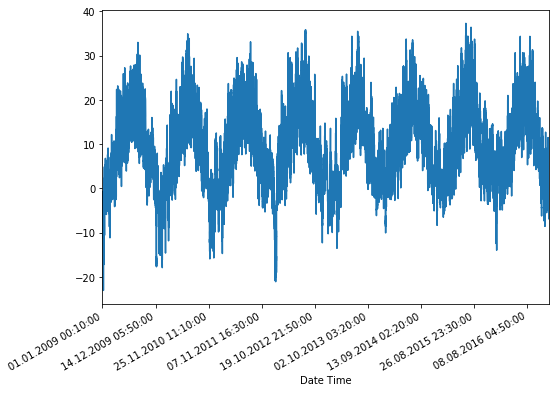

In [10]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [0]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [15]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

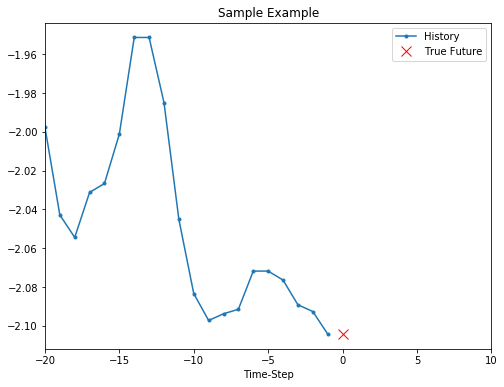

In [18]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

#### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

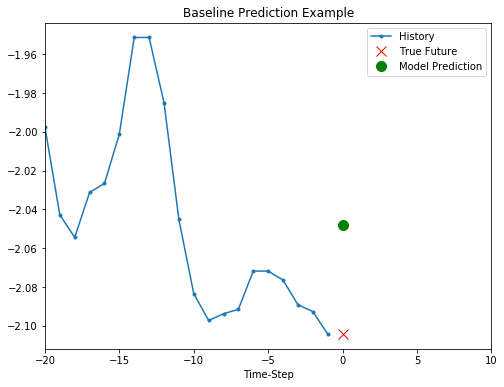

In [20]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

#### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Tem Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [21]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

W0813 11:19:46.800031 140499302823808 deprecation.py:323] From /tensorflow-2.0.0b1/python3.6/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The following visualisation should help you understand how the data is represented after batching.

![Time Series](https://raw.githubusercontent.com/tensorflow/docs/master/site/en/r2/tutorials/text/images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given. This shape can be inferred from dataset created.

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [23]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [24]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0262 - val_loss: 0.0196
Epoch 9/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0253 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0227 - val_lo

###### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

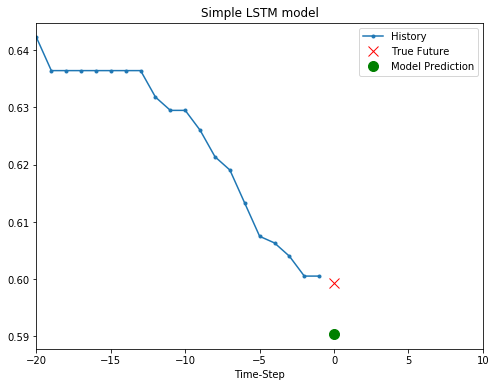

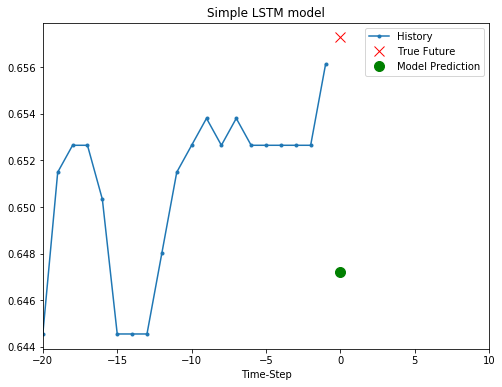

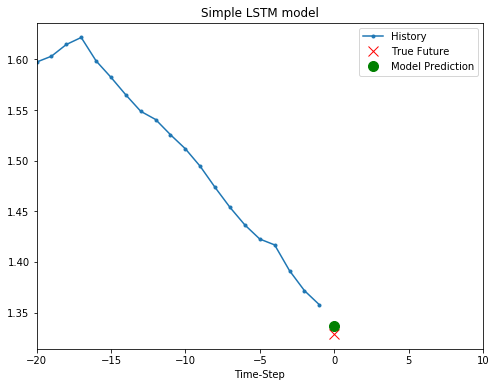

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

#### Part 2: Forecast a multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [27]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc849955358>,
      dtype=object)

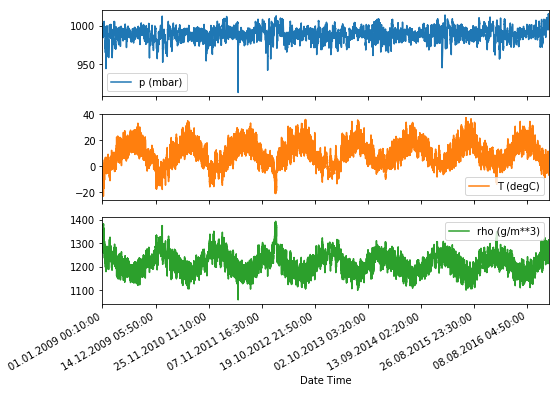

In [28]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [0]:
dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

In [0]:
dataset = (dataset-data_mean)/data_std

##### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)


Let's look at a single data-point.


In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 27s 136ms/step - loss: 0.3192 - val_loss: 0.2692
Epoch 2/10
200/200 [==============================] - 26s 130ms/step - loss: 0.2688 - val_loss: 0.2504
Epoch 3/10
200/200 [==============================] - 26s 130ms/step - loss: 0.2677 - val_loss: 0.2502
Epoch 4/10
200/200 [==============================] - 28s 139ms/step - loss: 0.2638 - val_loss: 0.2496
Epoch 5/10
200/200 [==============================] - 27s 135ms/step - loss: 0.2319 - val_loss: 0.2437
Epoch 6/10
200/200 [==============================] - 27s 136ms/step - loss: 0.2466 - val_loss: 0.2743
Epoch 7/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2463 - val_loss: 0.2648
Epoch 8/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2455 - val_loss: 0.2434
Epoch 9/10
200/200 [==============================] - 27s 133ms/step - loss: 0.2498 - val_loss: 0.2526
Epoch 10/10
200/200 [==============================] - 27s 134ms/step - l

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

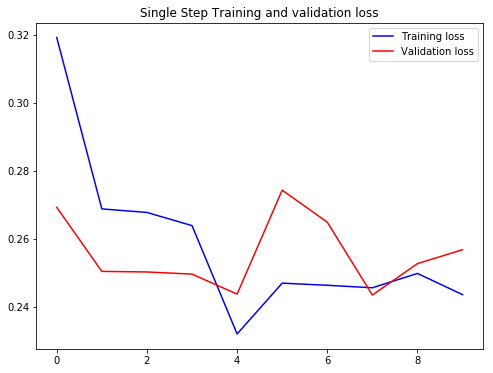

In [39]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

###### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

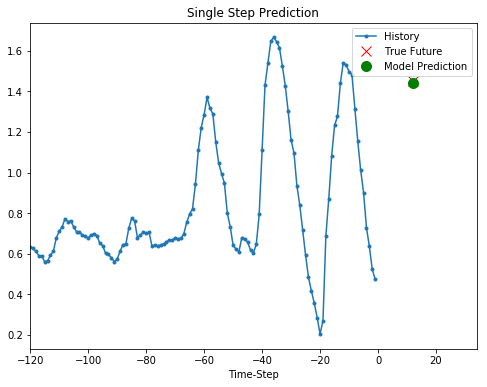

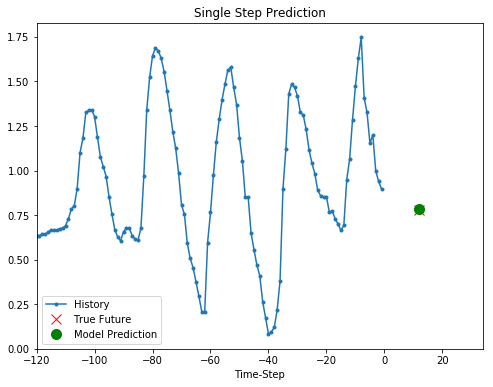

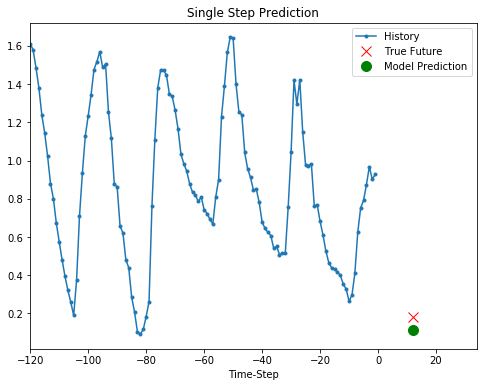

In [40]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

##### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [0]:
# single_step=False is the default, but re-emphasized here
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP,
                                               single_step=False)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP,
                                               single_step=False)

Let's check out a sample data-point.

In [42]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

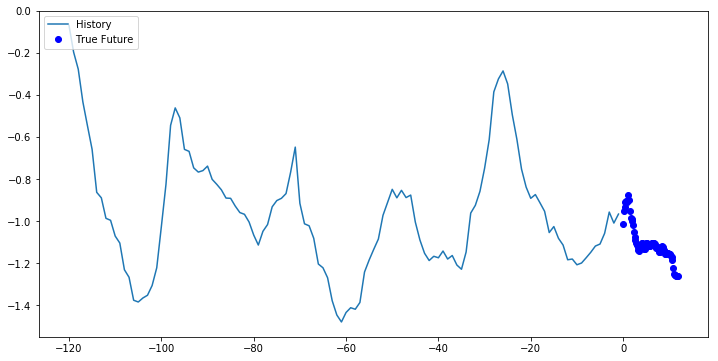

In [45]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [47]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [48]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 47s 234ms/step - loss: 92.9627 - val_loss: 0.3312
Epoch 2/10
200/200 [==============================] - 45s 223ms/step - loss: 0.3395 - val_loss: 0.2953
Epoch 3/10
200/200 [==============================] - 44s 222ms/step - loss: 0.3042 - val_loss: 0.2328
Epoch 4/10
200/200 [==============================] - 44s 222ms/step - loss: 0.2437 - val_loss: 0.2201
Epoch 5/10
200/200 [==============================] - 44s 219ms/step - loss: 0.2045 - val_loss: 0.2078
Epoch 6/10
200/200 [==============================] - 47s 234ms/step - loss: 0.2151 - val_loss: 0.2059
Epoch 7/10
200/200 [==============================] - 47s 235ms/step - loss: 0.2075 - val_loss: 0.2153
Epoch 8/10
200/200 [==============================] - 47s 237ms/step - loss: 0.2050 - val_loss: 0.1958
Epoch 9/10
200/200 [==============================] - 47s 237ms/step - loss: 0.2080 - val_loss: 0.1971
Epoch 10/10
200/200 [==============================] - 47s 237ms/step - 

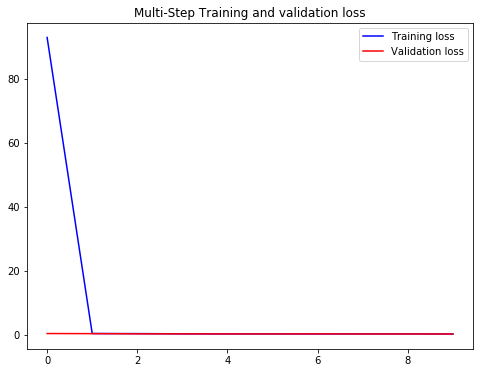

In [49]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

###### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

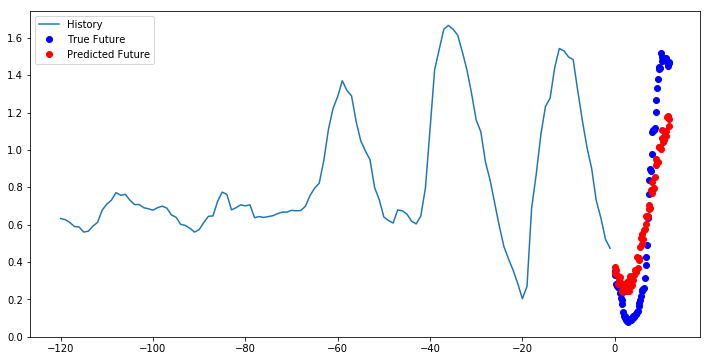

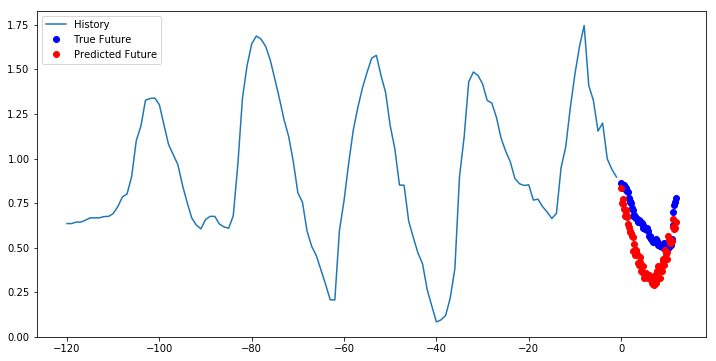

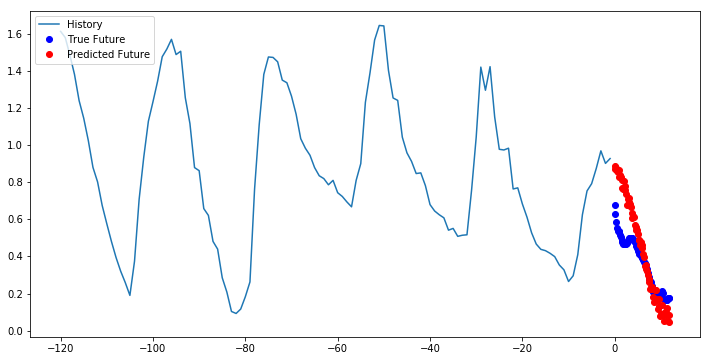

In [50]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

#### Next steps
This tutorial was a quick introduction to time series forecasting using an RNN. You may now try to predict the stock market and become a billionaire.

In addition, you may also write a generator to yield data (instead of the uni/multivariate_data function), which would be more memory efficient. You may also check out this [time series windowing](https://www.tensorflow.org/beta/guide/data#time_series_windowing) guide and use it in this tutorial.

For further understanding, you may read Chapter 15 of [Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), 2nd Edition and Chapter 6 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

## Using CNNs to predict timeseries

We follow parts of two tutorials here. The first part comes from a helpful (and more extensive) article here: [How to Develop Convolutional Neural Network Models for Time Series Forecasting.](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/)

The second part is a small piece of the inspiration behind this post: [Reading charts with Convolutional Neural Networks
Technical Analysis using CNNs](https://towardsdatascience.com/reading-charts-with-convolutional-neural-networks-cbaabdd5f478), where the main contribution is that time-series can be turned into images (however inefficiently) AND that translational invariance is good for image classification (it doesn't matter where the cat is centered), but bad for time-series (it does matter where an oscillation blast occurs).

In [0]:
# restart the runtime
import os
os.kill(os.getpid(), 9)

In [1]:
# cnn example
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


Using TensorFlow backend.


###Data Preparation
Before a univariate series can be modeled, it must be prepared.

The CNN model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the model can learn.

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

The split_sequence() function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps and the output is a single time step.

The number of time steps as input is the number we chose when preparing our dataset as an argument to the split_sequence() function.

The input shape for each sample is specified in the input_shape argument on the definition of the first hidden layer.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape

Our split_sequence() function in the previous section outputs the X with the shape [samples, timesteps], so we can easily reshape it to have an additional dimension for the one feature.

In [0]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# define input sequence
raw_seq = np.sin(list(range(0,9)) )

# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. This is followed by perhaps a second convolutional layer in some cases, such as very long input sequences, and then a pooling layer whose job it is to distill the output of the convolutional layer to the most salient elements.

The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flatten layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.

We can define a 1D CNN Model for univariate time series forecasting as follows.

The CNN does not actually view the data as having time steps, instead, it is treated as a sequence over which convolutional read operations can be performed, like a one-dimensional image.

In this example, we define a convolutional layer with 64 filter maps and a kernel size of 2. This is followed by a max pooling layer and a dense layer to interpret the input feature. An output layer is specified that predicts a single numerical value.

The model is fit using the efficient Adam version of stochastic gradient descent and optimized using the mean squared error, or ‘mse‘, loss function.

Once the model is defined, we can fit it on the training dataset.

W0813 12:43:29.433505 140622869489536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 12:43:29.493149 140622869489536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 12:43:29.503129 140622869489536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 12:43:29.563638 140622869489536 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0813 12:43:29.610937 140622869489536 deprecation_wrapp

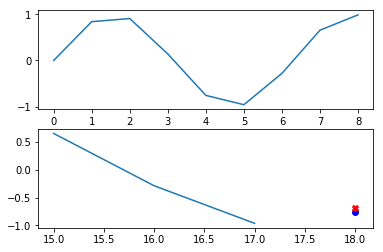

In [3]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array(np.sin([15, 16, 17]))
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(array(list(range(0,9))),raw_seq)
ax=fig.add_subplot(212)
ax.plot(np.array([15, 16, 17]),x_input[0,:])
ax.scatter(18,np.sin(18),c='b')
ax.scatter(18,yhat,c='r',marker='X')

### Multivariate CNN Models
Multivariate time series data means data where there is more than one observation for each time step. In this case we use it to remove the translational invariance from the CNN model, by forcing it to use a time index. In order for this to work in real life you would need to repeat the time series multiple times but include different values for the zeroth timestep.

There are two main models that we may require with multivariate time series data; they are:

### Multiple Input Series.
Multiple Parallel Series.
Let’s take a look at each in turn.

Multiple Input Series
A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.

The input time series are parallel because each series has observations at the same time steps.

We can demonstrate this with a simple example of two parallel input time series where the output series is the simple addition of the input series.

In [0]:


# define input sequence
in_seq1 = np.sin(list(range(0,9)) )
in_seq2 = array(list(range(0,9)))
out_seq = np.cos(list(range(0,9)) )

In [0]:

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

A 1D CNN model needs sufficient context to learn a mapping from an input sequence to an output value. CNNs can support parallel input time series as separate channels, like red, green, and blue components of an image. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

If we chose three input time steps, then the first sample would look as follows:

In [0]:

 
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = array([[np.sin(15), 15], [np.sin(16), 16], [np.sin(17), 17]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)



fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(in_seq2,in_seq1,c='b')
ax.plot(in_seq2,in_seq2,c='g')
ax.plot(in_seq2,out_seq,c='m')
ax=fig.add_subplot(212)
ax.plot(np.array([15, 16, 17]),x_input[0,:,0],c='b')
ax.plot(np.array([15, 16, 17]),np.cos(np.array([15, 16, 17])),c='m')
ax.scatter(18,np.cos(18),c='m')
ax.scatter(18,yhat,c='r',marker='X')

for more such as analyzing multivariate timeseries *separately* (useful if they have different timescales e.g. one is detrended, the other is the trend), or making multivariate predictions etc see the original source.

### Converting timeseries to 2D images for use in CNNs

There are any number of ways that timeseries can be converted into images. We show two classics, but why would anyone want to?! A lot more research has gone into deep processing of images than timeseries. Huge well-functioning models already exist for images. If you can reformulate timeseries forecasting as image-to-image transfer  or a multitudinous label classification problem then you *might* be able to leverage transfer learning and take a shortcut.

In what follows, we show how to turn timeseries into images. The first is a non-sparse method called Gramian Angular Field which you can read about here:

https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3

After this we move on to recurrence plots. 

In [0]:
!git clone https://github.com/johannfaouzi/pyts.git

In [0]:
cd pyts

In [0]:
!pip install .

In [0]:
cd ..

In [0]:
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
from pyts.datasets import load_gunpoint
from pyts.image import RecurrencePlot

# Parameters
X, _, _, _ = load_gunpoint(return_X_y=True)

In [0]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(X[3,:])

In [0]:


# Transform the time series into Gramian Angular Fields
gasf = GramianAngularField(image_size=24, method='summation')
X_gasf = gasf.fit_transform(X)
gadf = GramianAngularField(image_size=24, method='difference')
X_gadf = gadf.fit_transform(X)

# Show the images for the first time series
fig = plt.figure(figsize=(12, 7))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[0], X_gadf[0]]
titles = ['Gramian Angular Summation Field',
          'Gramian Angular Difference Field']

print('The shape of the image matrix is')
print(X_gasf[0].shape)
print('total number of data points is {}'.format(X_gasf[0].shape[0]*X_gasf[0].shape[1]))
print('The original data had {} points.'.format(X.shape[1]))
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 16})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)

plt.suptitle('Gramian Angular Fields', y=0.92, fontsize=20)
plt.show()

Note that the size of the gramian field images are much larger than the original time series. This limits the length of time series that can be analyzed. This is the achilles heal of borrowing from the 2D imaging world. 

In this example the original matrix should have been 150x150 but was reduced, so it is an approximation. That means that it still takes more space to store, but nonetheless does not contain all of the original information! 

Another method is to use "recurrance plots". In a traditional recurrence plot the matrix would be 150x150 and have values either 0, or 1. A 1 in the jth column and kth row means that the jth and kth time-points have the same value. This means that it also loses much of the original information. 

However, if we replace each "1" by the value of the original time series we can retain complete information. Of course this does require rescaling the original timeseries to be strictly positive so that "0" can continue to mark an absence of correlation. 

Lastly, the recurrence plot is simmetric, this means that it can be reduced from 150x150 to 150x75.
 

In [0]:
# Recurrence plot transformation
rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(6, 6))
plt.imshow(X_rp[0], cmap='Greys', origin='upper')
plt.title('Recurrence Plot', fontsize=18)
plt.show()

Here we restore the original information. 

In [0]:
positive_shifted_data=X[0,:]-X[0,:].min()+0.1*(X[0,:].max()-X[0,:].min())
full_data_recurrence=np.multiply(X_rp[0],positive_shifted_data)
full_data_recurrence=np.asarray(255*full_data_recurrence/full_data_recurrence.max(),dtype=np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(full_data_recurrence, cmap='gray', vmin=0, vmax=255)
plt.title('Recurrence Plot', fontsize=18)
plt.show()

Here we remove redundant information.

In [0]:
N=full_data_recurrence.shape[0]
less_redundant_representation_part1=full_data_recurrence[:int(N/2),:].copy()
less_redundant_representation_part2=full_data_recurrence[:int(N/2),:int(N/2)].copy()
less_redundant_representation_part3=full_data_recurrence[int(N/2):,int(N/2):].copy()
# rotate the bit in the lower right into the correct position
less_redundant_representation_part3=np.fliplr(np.fliplr(less_redundant_representation_part3).T).T
# stick the upper triangular bit from the lower right into the lower triangular bit of the upper left
less_redundant_representation_part2[np.tril_indices(int(N/2))]=less_redundant_representation_part3[np.tril_indices(int(N/2))]


less_redundant_representation_part1[:int(N/2),:int(N/2)]=less_redundant_representation_part2

plt.figure(figsize=(6, 6))
plt.imshow(less_redundant_representation_part1, cmap='gray', vmin=0, vmax=255)
plt.title('Recurrence Plot', fontsize=18)
plt.show()

## Using Neural ODE estimators to model time series

Here we have two more kinds of deep learning approaches and a suite of tools to help you apply deeplearning in more general situations.

This section is titled "Neural ODEs" which is a kind of network which does not have traditional links and weights. Instead of thinking of propagation through a network as a series of vector transformations occuring at distinct layers it is thought of as the evolution of a vector in a dynamical system of differential equations. This lets the network emulate infinitely many layers. It is natural then to try to use this to model time series. However it is much more expressive than that, a lot of hype surrounds neural ODEs as a door to the next generation of neural networks rit-large. 

At the core of the method is the use of a normal ODE integrator which is fed new weights at each timestep. This  is hardly the first time people have tried that. The RKNN model trains a traditional recurrent neural network to predict the vector field of derivatives when you feed it the time evolution of a dynamical system coming from your measurements or another simulation. This work emerged directly from efforts to find a dynamical system which describes data (such as SINDy). 

**Neural ODEs**

[Neural ODEs github](https://github.com/rtqichen/torchdiffeq/tree/master/examples)
[Neural ODEs to model timeseries](https://github.com/rtqichen/torchdiffeq/blob/master/examples/latent_ode.py)

[Summary of neural ODEs](https://towardsdatascience.com/paper-summary-neural-ordinary-differential-equations-37c4e52df128)

[Neural ODE paper](https://arxiv.org/pdf/1806.07366.pdf)

[Augmented neural ODEs (dimensionality expanded version)](https://github.com/EmilienDupont/augmented-neural-odes)

**RKNN modeling of vector derivative fields**

[RKNN Deep learning of dynamics and signal noise decomposition with time-stepping constraints.](https://github.com/snagcliffs/RKNN)

[RKNN example with Lorenz system](https://colab.research.google.com/github/snagcliffs/RKNN/blob/master/Lorenz%20---%2010%25%20Noise.ipynb)

**Resources for implementation of utility functions enhanced by deeplearning**

[continuous topological transformations of probability distributions](https://github.com/rtqichen/ffjord)

[Automatic gradients of arbitrary code](https://github.com/google/jax)